In [41]:
import pandas as pd
import numpy as np
import mplfinance as mpf
from math import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)
import datetime as dt
import random
from tqdm import tqdm
import pandas_ta as ta
import seaborn as sns
plt.style.use('dark_background')
from qfin_lib import __load_alldata, get_price_channel, row_top, row_bottom, rw_extremes

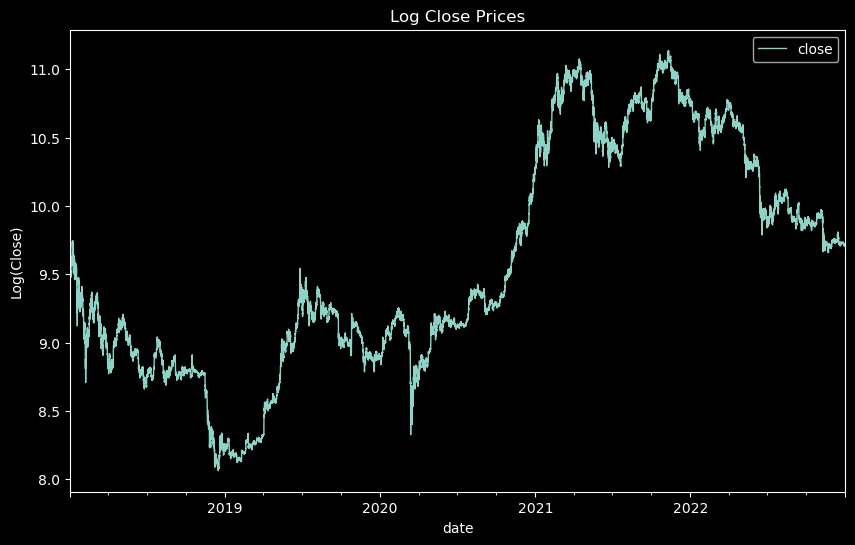

In [42]:
btcusd = pd.read_csv('BTCUSDT3600.csv')
btcusd['date'] = btcusd['date'].astype('datetime64[s]')
btcusd = btcusd.set_index('date')
btcusd.dropna(inplace=True)

btcusd['close'] = np.log(btcusd['close'])
btcusd['open']  = np.log(btcusd['open'])
btcusd['high']  = np.log(btcusd['high'])
btcusd['low']   = np.log(btcusd['low'])

plt.figure(figsize=(10, 6))
btcusd.close.plot()
plt.title('Log Close Prices')
plt.ylabel('Log(Close)')
plt.grid(False)
plt.legend()
plt.show()

In [43]:
def addMovingAverages(df: pd.DataFrame, smaPeriod: int = 80, atrPeriod: int = 80):

    df['middle_band'] = ta.sma(df.close, length=smaPeriod)
    df['atr'] = ta.atr(df.high, df.low, df.close, length=atrPeriod)
    
    df['trend'] = ta.sma(df.close, length=250)
    
    df['band_upper'] = df['middle_band'] + (2.2 * df['atr'])
    df['band_lower'] = df['middle_band'] - (2.2 * df['atr'])
    
    return df

In [44]:
data = addMovingAverages(btcusd, 80, 80)

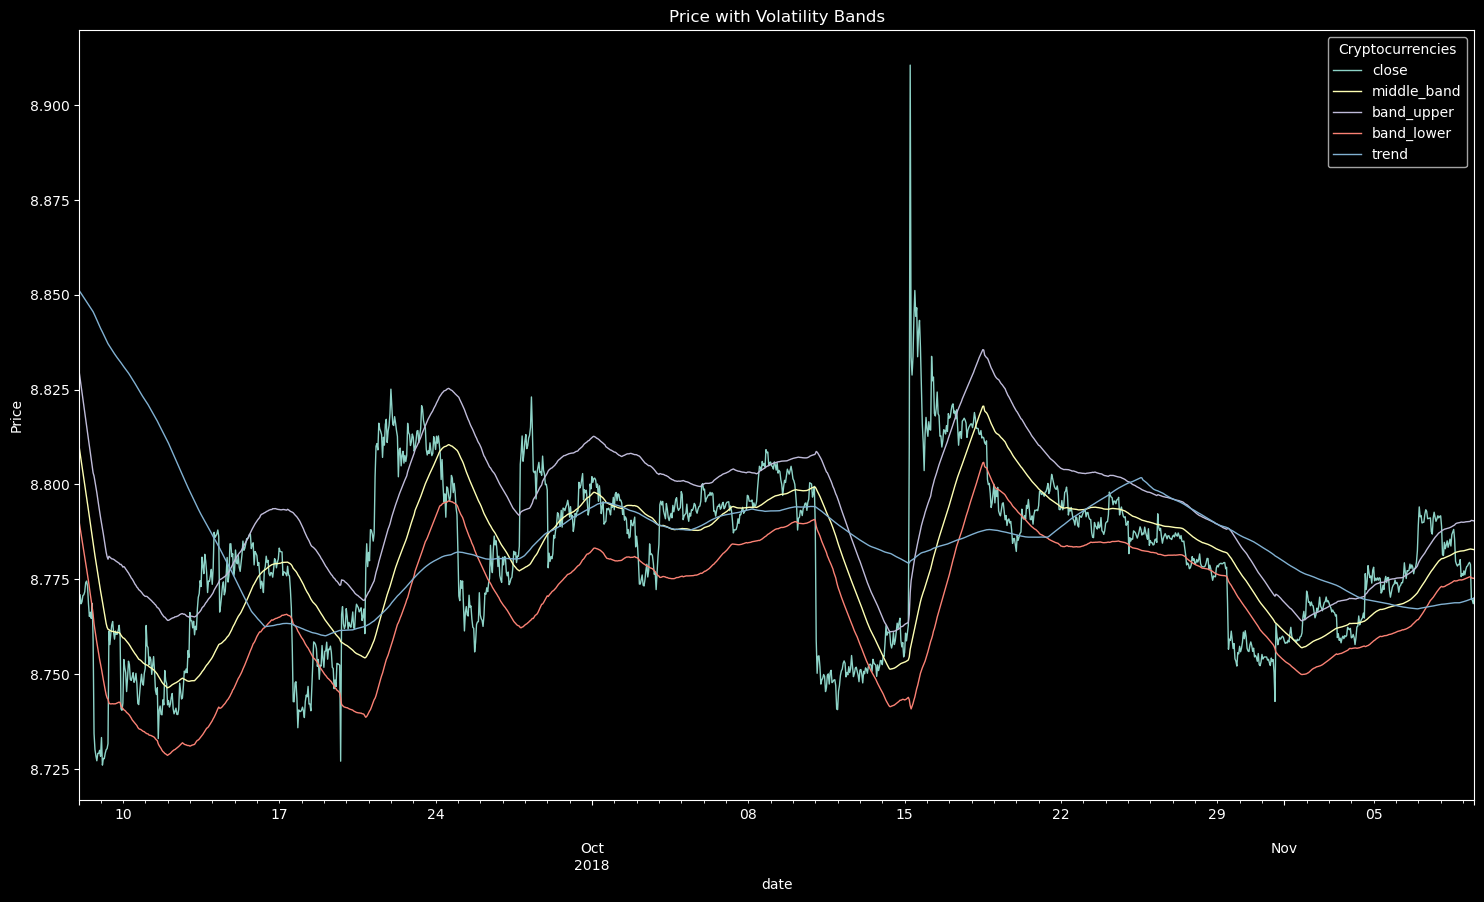

In [45]:
plt.style.use('dark_background')
data[6000:7500][['close', 'middle_band', 'band_upper', 'band_lower', 'trend']].plot()
plt.ylabel("Price")
plt.title("Price with Volatility Bands")
plt.legend(title="Cryptocurrencies")
plt.grid(False)
plt.show()

In [46]:
def ATRBreakoutStrategy(df: pd.DataFrame):
    
    sig = np.zeros(len(df.close))
    
    close = df.close.to_numpy()
    upper = df.band_upper.to_numpy()
    lower = df.band_lower.to_numpy()
    middle = df.middle_band.to_numpy()
    trend = df.trend.to_numpy()
    
    currentPosition = 0
    
    returns = []
    
    entry = -1
    
    for i in range(0, len(df.close)):
        
        if close[i] > upper[i] and currentPosition == 0:
            currentPosition = 1
            entry = close[i]
            
        if close[i] < lower[i] and currentPosition == 0:
            currentPosition = -1
            entry = close[i]
        
        if currentPosition == 1:
            if close[i] >= middle[i]:
                sig[i] = 1
            else:
                sig[i] = 0
                currentPosition = 0
                returns.append(close[i-1] - entry)
                entry = -1
        elif currentPosition == -1:
            if close[i] <= middle[i]:
                sig[i] = -1
            else:
                sig[i] = 0
                currentPosition = 0
                returns.append(entry - close[i-1])
    return sig, returns

In [47]:
def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    # Gets trade entry and exit times from a signal
    # that has values of -1, 0, 1. Denoting short,flat,and long.
    # No position sizing.

    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        
        if signal[i] == 0.0 and last_sig == -1.0: # Short exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            short_trades.append(open_trade)
            open_trade = None

        if signal[i] == 0.0  and last_sig == 1.0: # Long exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            long_trades.append(open_trade)
            open_trade = None

        last_sig = signal[i]
        
    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['return'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price']
    short_trades['return'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    
    long_trades['type'] = 1
    short_trades['type'] = -1
    all_trades = pd.concat([long_trades, short_trades])
    all_trades = all_trades.sort_index()
    
    return long_trades, short_trades, all_trades

Profit Factor: 1.047154976776066


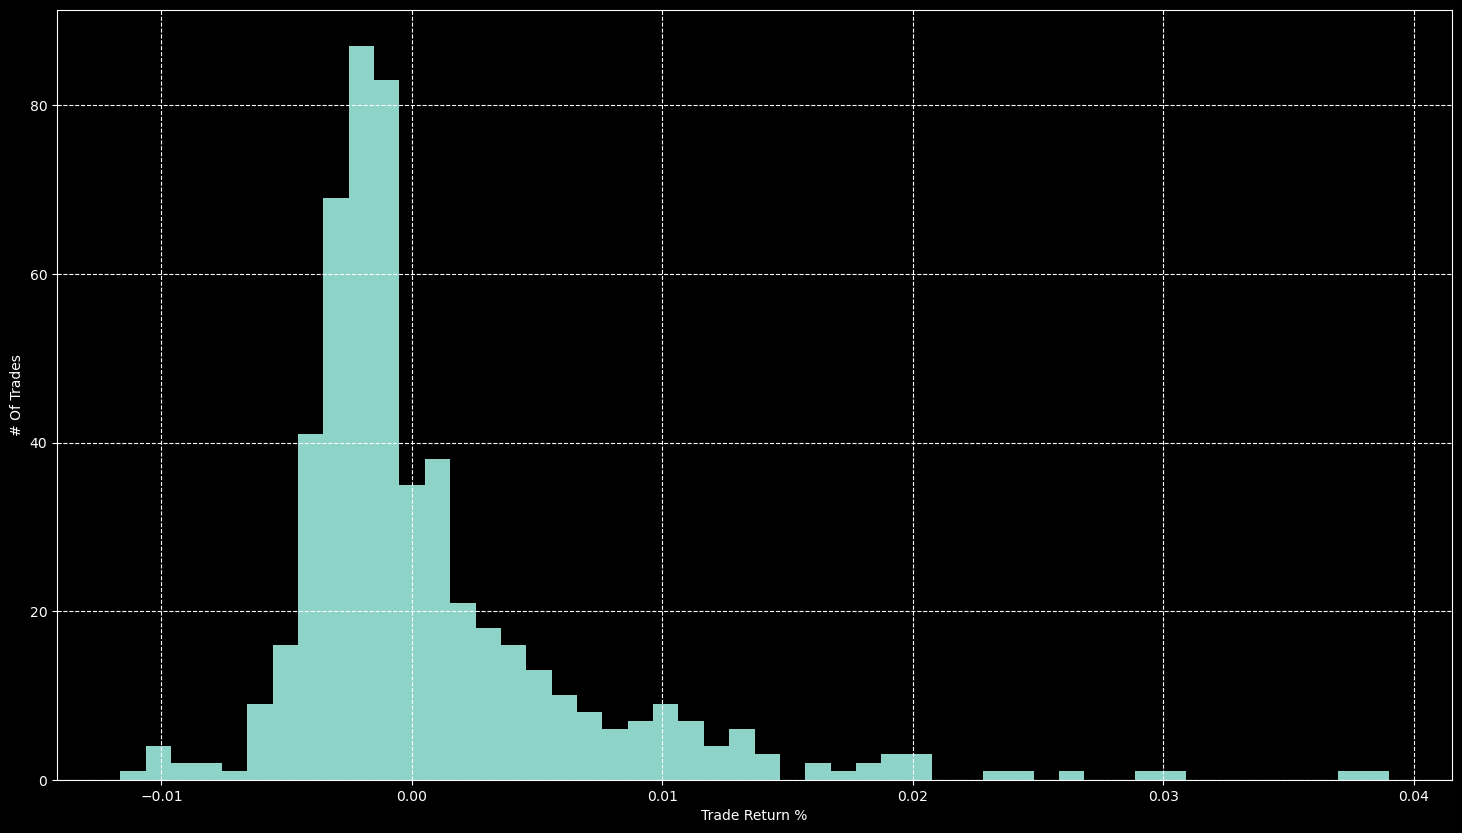

Trades Avg: 0.021481770243533187
Trades Win Rate: 0.5149812734082397
Trades Time In Market: 0.3648768911302284


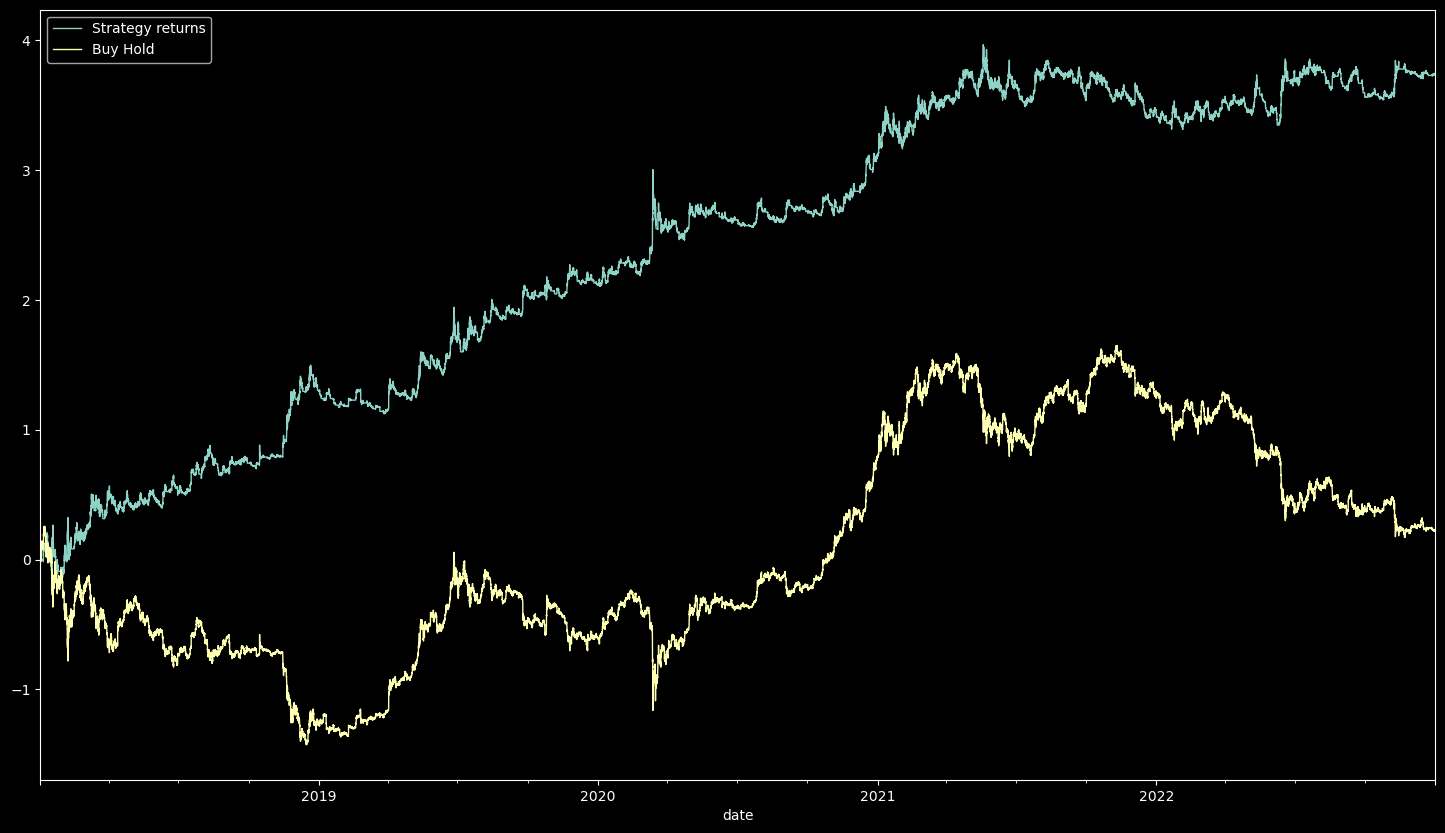

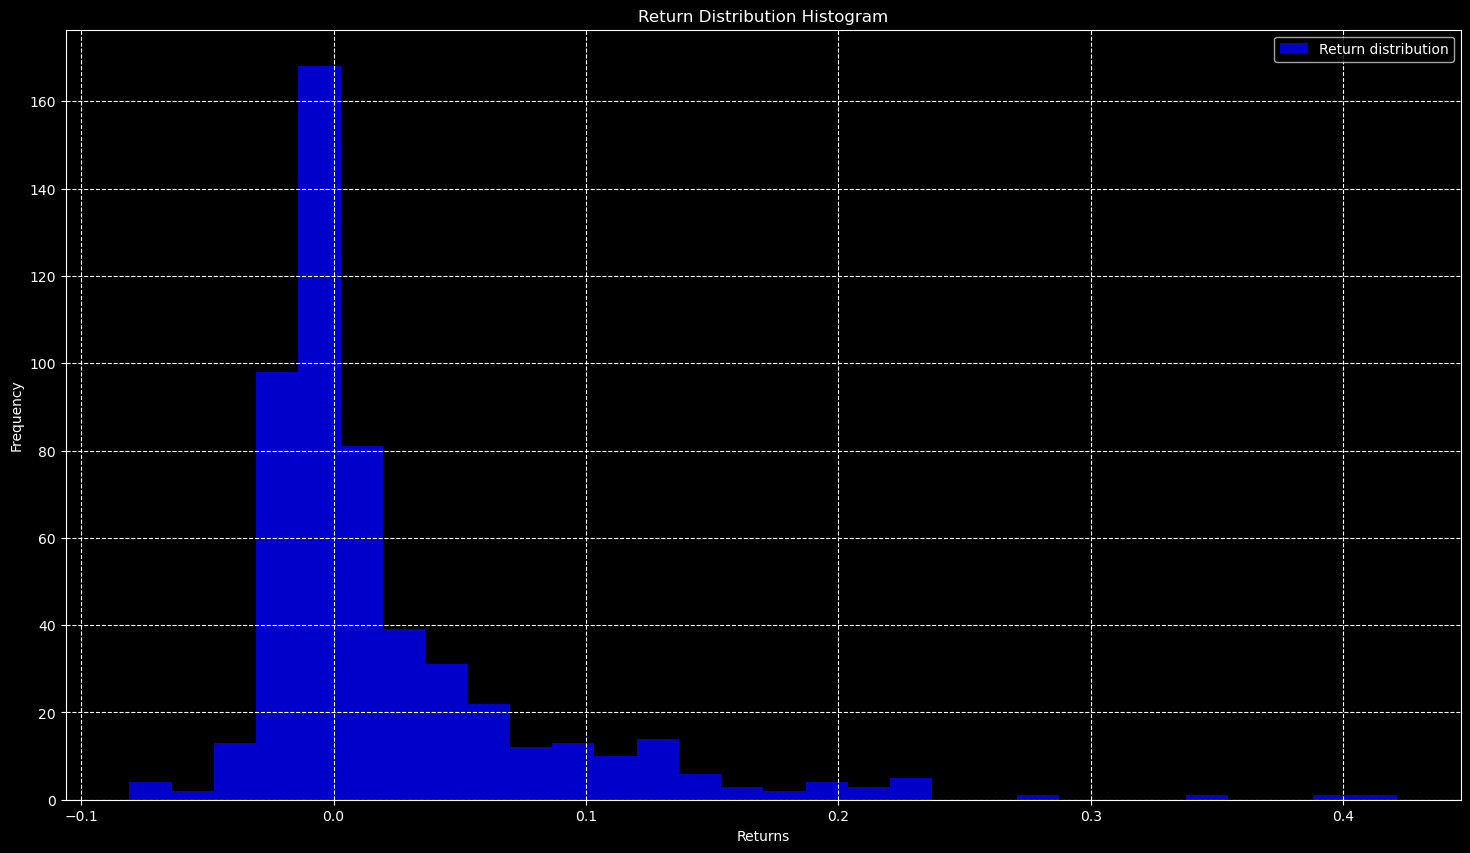

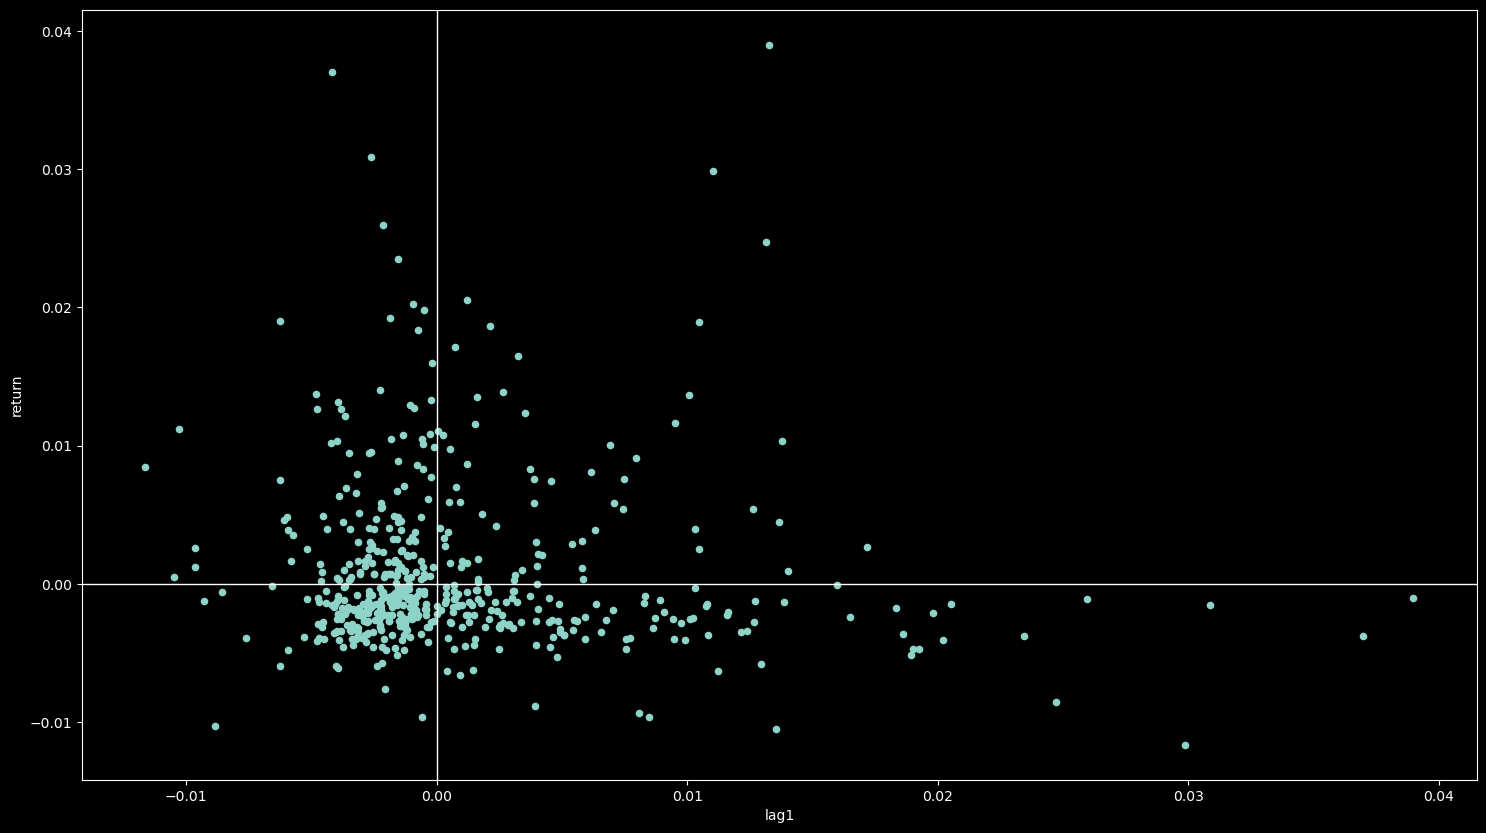

In [48]:
signal, returns = ATRBreakoutStrategy(btcusd)
btcusd['signal'] = signal
btcusd['r'] = (btcusd['close']).diff().shift(-1)
strat_r = btcusd['signal'] * btcusd['r']  
all_r = btcusd['r']

pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
print(f"Profit Factor: {pf}")

REAL_PF = pf

returns = pd.DataFrame(returns, columns=['returns'])
returns = returns['returns']

long_trades, short_trades, all_trades = get_trades_from_signal(btcusd, btcusd['signal'])
all_trades['return'].hist(bins=50)
plt.xlabel("Trade Return %")
plt.ylabel("# Of Trades")
plt.show()


print("Trades Avg:", np.mean(returns))
print("Trades Win Rate:", len(returns[returns > 0]) / len(returns))
print("Trades Time In Market:", len(btcusd[btcusd['signal'] > 0]) / len(btcusd)) 

# Plot cumulative returns
strat_r.cumsum().plot(label='Strategy returns')
btcusd['r'].cumsum().plot(label='Buy Hold')
plt.grid(False)
plt.legend()
plt.show()

# Plot histogram of returns
plt.hist(returns, bins=30, color='blue', alpha=0.8, label='Return distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Return Distribution Histogram')
plt.legend()
plt.show()

all_trades['lag1'] = all_trades['return'].shift(1)
all_trades.plot.scatter('lag1', 'return')
plt.axvline(0)
plt.axhline(0)
plt.grid(False)
plt.show()

100%|███████████████████████████████████████████| 19/19 [00:06<00:00,  2.78it/s]


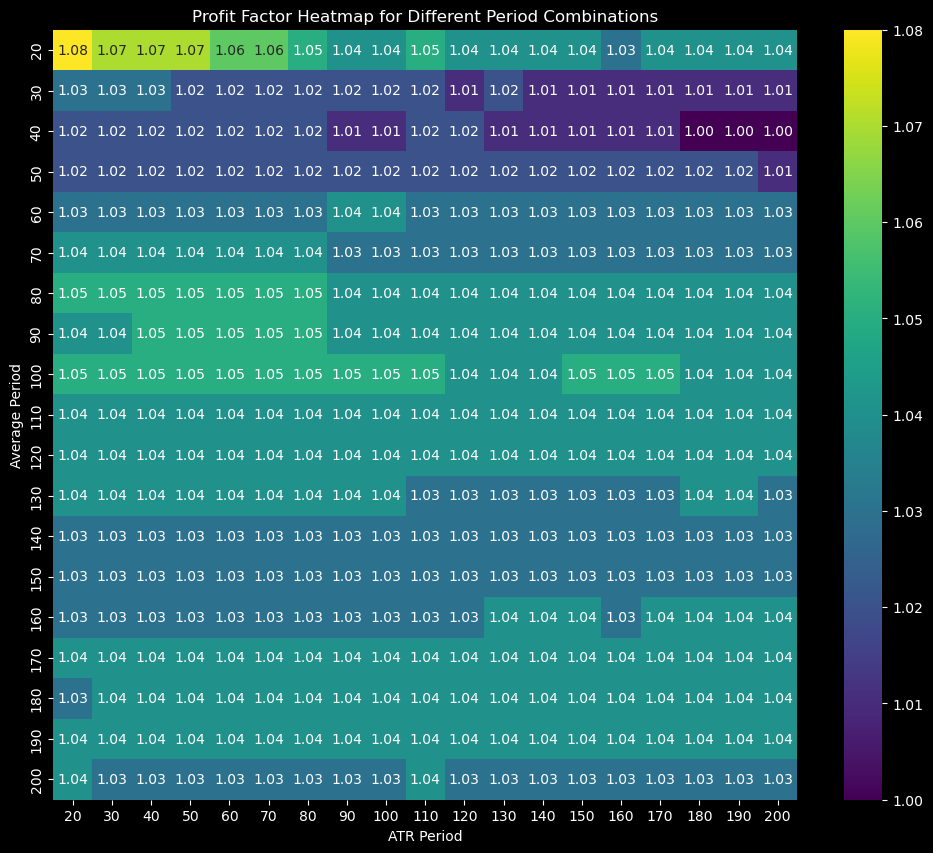

In [49]:
btcusd = pd.read_csv('BTCUSDT3600.csv')
btcusd['date'] = btcusd['date'].astype('datetime64[s]')
btcusd = btcusd.set_index('date')
btcusd.dropna(inplace=True)

btcusd['close'] = np.log(btcusd['close'])
btcusd['open']  = np.log(btcusd['open'])
btcusd['high']  = np.log(btcusd['high'])
btcusd['low']   = np.log(btcusd['low'])

# Define the range for moving averages
ma_ranges = range(20, 201, 10)  # e.g., from 20 to 200 in steps of 10

# Initialize an empty dictionary to store profit factors
profit_factors = {}

# Iterate over all combinations of moving averages
for ma1 in tqdm(ma_ranges):
    for atr in ma_ranges:
        # Apply the moving averages and the strategy
        data = btcusd.copy()
        data = addMovingAverages(data, ma1, atr)
        signal, returns = ATRBreakoutStrategy(data)
        data['signal'] = signal
        data['r'] = (data['close']).diff().shift(-1)
        strat_r = data['signal'] * data['r']

        # Calculate and store the profit factor
        pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
        profit_factors[(ma1, atr)] = round(pf, 2) if strat_r[strat_r < 0].abs().sum() != 0 else np.nan

# Convert the dictionary to a DataFrame for heatmap plotting
pf_df = pd.DataFrame(index=ma_ranges, columns=ma_ranges)
for (ma1, atr), pf in profit_factors.items():
    pf_df.loc[ma1, atr] = pf

pf_df = pf_df.apply(pd.to_numeric)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pf_df, annot=True, cmap='viridis', fmt='.2f')
plt.title('Profit Factor Heatmap for Different Period Combinations')
plt.xlabel('ATR Period')
plt.ylabel('Average Period')
plt.grid(False)
plt.show()

Permuting Price paths. 



100%|███████████████████████████████████████| 1000/1000 [06:19<00:00,  2.63it/s]
/Users/suchismit/anaconda3/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


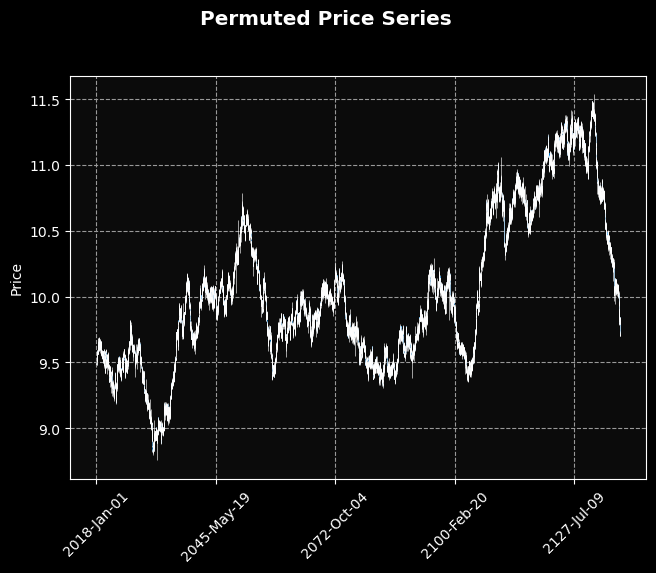

In [50]:
print("Permuting Price paths. \n")

permuted_price_paths = []

permutations = 1000

btcusd['log_close_open'] =     np.log(btcusd['close'] / btcusd['open'])
btcusd['log_high_open'] =      np.log(btcusd['high'] / btcusd['open'])
btcusd['log_low_open'] =       np.log(btcusd['low'] / btcusd['open'])
btcusd['log_open_prev_close'] =np.log(btcusd['open'] / btcusd['close'].shift(1))

btcusd = btcusd.dropna()

for i in tqdm(range(0, permutations)):

    shuffled_close_open = btcusd['log_close_open'].sample(frac=1).reset_index(drop=True)
    shuffled_high_open = btcusd['log_high_open'].sample(frac=1).reset_index(drop=True)
    shuffled_low_open = btcusd['log_low_open'].sample(frac=1).reset_index(drop=True)
    shuffled_open_prev_close = btcusd['log_open_prev_close'].sample(frac=1).reset_index(drop=True)

    permuted_bars = {'open': [], 'high': [], 'low': [], 'close': []}

    for i in range(len(shuffled_close_open)):
        if i == 0:
            open_price = (btcusd['open'].iloc[0])
            close_price = open_price * np.exp(shuffled_close_open.iloc[0])
            high_price = open_price * np.exp(shuffled_high_open.iloc[0])
        
            low_price = open_price * np.exp(shuffled_low_open.iloc[0])
        else:
            open_price = permuted_bars['close'][-1] * np.exp(shuffled_open_prev_close.iloc[i-1])
            close_price = open_price * np.exp(shuffled_close_open.iloc[i])
            high_price = open_price * np.exp(shuffled_high_open.iloc[i])
            low_price = open_price * np.exp(shuffled_low_open.iloc[i])

        permuted_bars['open'].append(open_price)
        permuted_bars['high'].append(high_price)
        permuted_bars['low'].append(low_price)
        permuted_bars['close'].append(close_price)

    permuted_bars = pd.DataFrame(permuted_bars)
    
    permuted_price_paths.append(permuted_bars)

selected_permuted_bar = permuted_price_paths[0].copy()

selected_permuted_bar.index = pd.date_range(start='2018-01-01', periods=len(selected_permuted_bar), freq='1D')

mpf.plot(selected_permuted_bar, type='candle', style='nightclouds', 
         title="Permuted Price Series", volume=False)

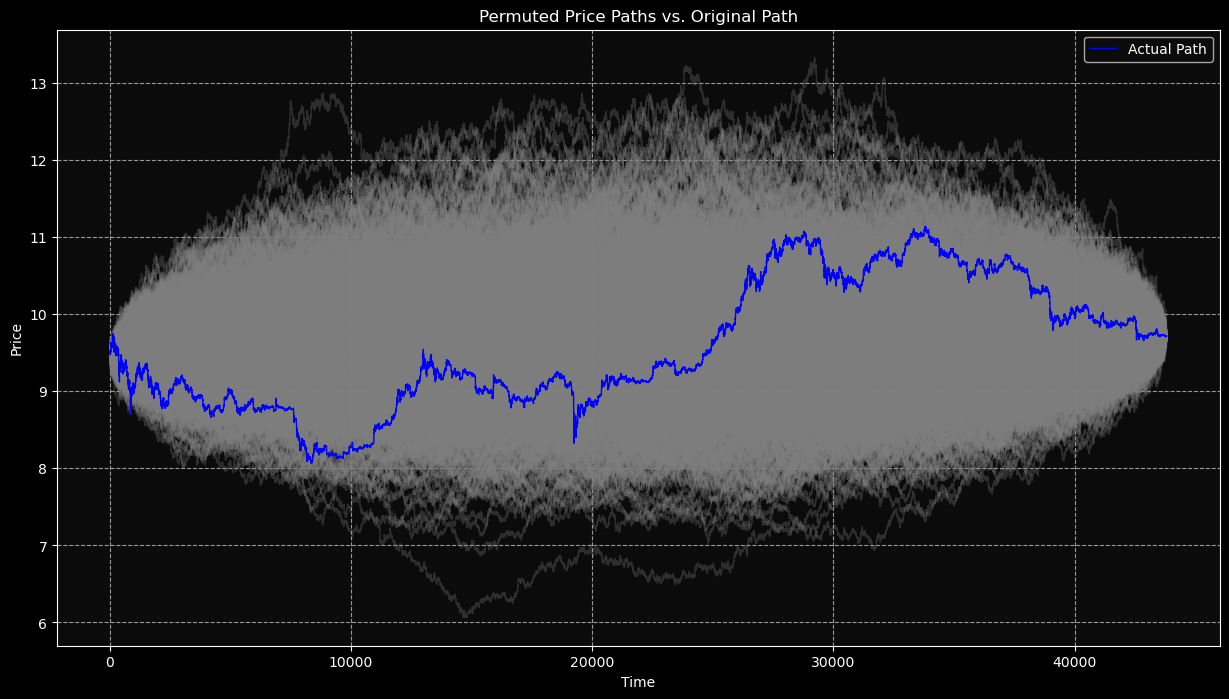

In [51]:
plt.figure(figsize=(15, 8))

# Plot each permuted path
for path in permuted_price_paths:
    plt.plot(path['close'], color='gray', alpha=0.3) 

original_path_aligned = btcusd['close'].iloc[1:].to_numpy()
plt.plot(original_path_aligned, color='blue', label='Actual Path')

plt.title('Permuted Price Paths vs. Original Path')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.show()

In [52]:
profit_factors = []

for _data in tqdm(permuted_price_paths, desc='Calculating profit factors on permuted price paths: '):
    data = _data.copy()
    data = addMovingAverages(data, 80, 80)
    signal, returns = ATRBreakoutStrategy(data)
    data['signal'] = signal
    data['r'] = (data['close']).diff().shift(-1)
    strat_r = data['signal'] * data['r']  
    all_r = data['r']

    pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
    profit_factors.append(pf)

Calculating profit factors on permuted price paths: 100%|█| 1000/1000 [00:19<00:


1.047154976776066


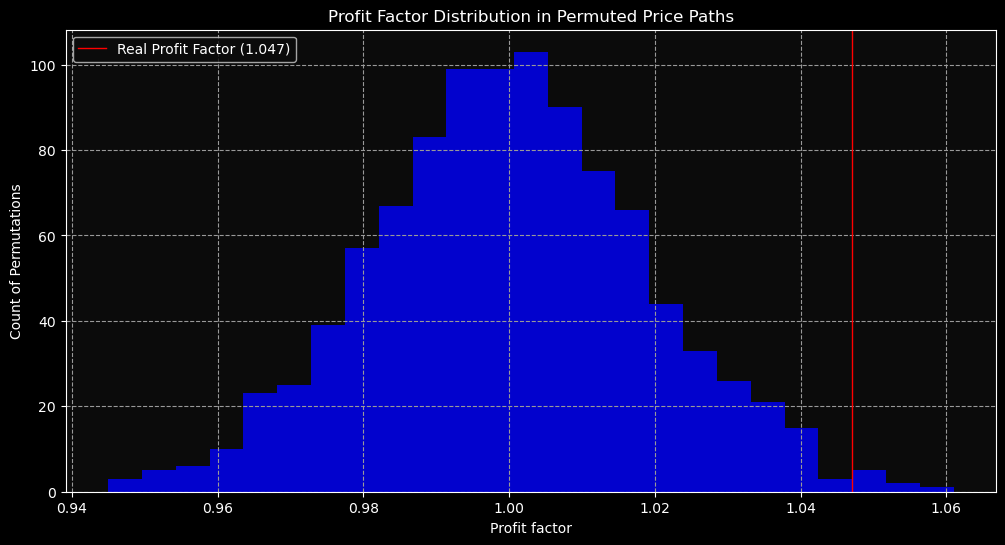

In [53]:
btcusd = pd.read_csv('BTCUSDT3600.csv')
btcusd['date'] = btcusd['date'].astype('datetime64[s]')
btcusd = btcusd.set_index('date')
btcusd.dropna(inplace=True)

btcusd['close'] = np.log(btcusd['close'])
btcusd['open']  = np.log(btcusd['open'])
btcusd['high']  = np.log(btcusd['high'])
btcusd['low']   = np.log(btcusd['low'])

data = btcusd.copy()
data = addMovingAverages(data, 80, 80)
signal, returns = ATRBreakoutStrategy(data)
data['signal'] = signal
data['r'] = (data['close']).diff().shift(-1)
strat_r = data['signal'] * data['r']  
all_r = data['r']

REAL_PF = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
print(REAL_PF)
rounded_profit_factors = [round(pf, 3) for pf in profit_factors]

real_profit_factors = round(REAL_PF, 3)

plt.figure(figsize=(12, 6))
plt.hist(rounded_profit_factors, bins=25, color='blue', alpha=0.8)
plt.axvline(real_profit_factors, color='red', label=f'Real Profit Factor ({real_profit_factors})')

plt.xlabel('Profit factor')
plt.ylabel('Count of Permutations')
plt.title('Profit Factor Distribution in Permuted Price Paths')
plt.legend()
plt.axis(True)
plt.show()

In [54]:
greater_or_equal_count = sum(pf >= real_profit_factors for pf in rounded_profit_factors)
p_value_approx = greater_or_equal_count / len(rounded_profit_factors) + 0.0001
# if greater_or_equal_count > 0:
# else:
#     p_value_approx = 0.001

print(f'Approximate p-value < {p_value_approx}')

Approximate p-value < 0.0081


In [55]:
# Outsample testing

In [56]:
btcusd = pd.read_csv('BTCUSDT3600.csv')
btcusd['date'] = btcusd['date'].astype('datetime64[s]')
btcusd = btcusd.set_index('date')
btcusd.dropna(inplace=True)

btcusd['close'] = np.log(btcusd['close'])
btcusd['open']  = np.log(btcusd['open'])
btcusd['high']  = np.log(btcusd['high'])
btcusd['low']   = np.log(btcusd['low'])

def getProfitFactors(df):
        # Define the range for moving averages
    ma_ranges = range(20, 201, 10)  # e.g., from 20 to 200 in steps of 10

    # Initialize an empty dictionary to store profit factors
    profit_factors = {}

    # Iterate over all combinations of moving averages
    for ma1 in tqdm(ma_ranges):
        for atr in ma_ranges:
            # Apply the moving averages and the strategy
            data = df.copy()
            data = addMovingAverages(data, ma1, atr)
            signal, returns = ATRBreakoutStrategy(data)
            data['signal'] = signal
            data['r'] = (data['close']).diff().shift(-1)
            strat_r = data['signal'] * data['r']

            # Calculate and store the profit factor
            pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
            profit_factors[(ma1, atr)] = round(pf, 2) if strat_r[strat_r < 0].abs().sum() != 0 else np.nan

    # Convert the dictionary to a DataFrame for heatmap plotting
    pf_df = pd.DataFrame(index=ma_ranges, columns=ma_ranges)
    for (ma1, atr), pf in profit_factors.items():
        pf_df.loc[ma1, atr] = pf

    pf_df = pf_df.apply(pd.to_numeric)
    return pf_df


def walkforward_optimization(df: pd.DataFrame, 
                             train_size: int, step_size: int):
    
    sig = np.zeros(len(df.close))
    
    close = df.close.to_numpy()
    currentPosition = 0 
    
    next_optimize = train_size
    notInit = True

    for i in range(len(df.close)):
        if i == next_optimize:
            start_i = i - train_size
            data = df[start_i:i]
            pfs = getProfitFactors(data)
            
            max_pf = pfs.max().max()
            optimal_params = pfs.stack().idxmax()
            optimal_ma, optimal_atr = optimal_params
            
            # Apply the optimal moving averages and ATR to the data
            df = addMovingAverages(df, optimal_ma, optimal_atr)
            
            upper = df.band_upper.to_numpy()
            lower = df.band_lower.to_numpy()
            middle = df.middle_band.to_numpy()
            
            next_optimize += step_size
            notInit = False
        
        if notInit == False:
            if close[i] > upper[i] and currentPosition == 0:
                currentPosition = 1
                entry = close[i]

            if close[i] < lower[i] and currentPosition == 0:
                currentPosition = -1
                entry = close[i]

            if currentPosition == 1:
                if close[i] >= middle[i]:
                    sig[i] = 1
                else:
                    sig[i] = 0
                    currentPosition = 0
                    returns.append(close[i-1] - entry)
                    entry = -1
            elif currentPosition == -1:
                if close[i] <= middle[i]:
                    sig[i] = -1
                else:
                    sig[i] = 0
                    currentPosition = 0
                    returns.append(entry - close[i-1])
                
    return sig    

100%|███████████████████████████████████████████| 19/19 [00:01<00:00, 17.65it/s]


Profit Factor: 1.0484206481544525


<Axes: xlabel='date'>

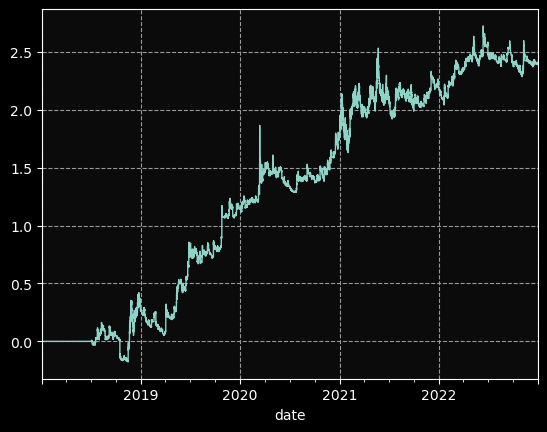

In [57]:
signal = walkforward_optimization(btcusd, 365 * 12, 365 * 6)
btcusd['signal'] = signal
btcusd['r'] = (btcusd['close']).diff().shift(-1)
strat_r = btcusd['signal'] * btcusd['r']  

pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
print(f"Profit Factor: {pf}")

strat_r.cumsum().plot(label='Brute force optimization')

In [58]:
from backtesting import Backtest, Strategy

btcusd = pd.read_csv('BTCUSDT3600.csv')
btcusd['date'] = btcusd['date'].astype('datetime64[s]')
btcusd = btcusd.set_index('date')
btcusd.dropna(inplace=True)

btcusd['close'] = np.log(btcusd['close'])
btcusd['open']  = np.log(btcusd['open'])
btcusd['high']  = np.log(btcusd['high'])
btcusd['low']   = np.log(btcusd['low'])

btcusd = addMovingAverages(btcusd, 80, 80)
signal, returns = ATRBreakoutStrategy(btcusd)
btcusd['signal'] = signal
print(btcusd.columns)
btcusd.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'middle_band', 'atr', 'trend',
       'band_upper', 'band_lower', 'signal']
btcusd.index.rename('Date', inplace=True)
btcusd.dropna(inplace=True)

print(btcusd.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'middle_band', 'atr', 'trend',
       'band_upper', 'band_lower', 'signal'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'middle_band', 'atr', 'trend',
       'band_upper', 'band_lower', 'signal'],
      dtype='object')


In [59]:
class _ATRBreakout(Strategy):

    def init(self):

        self.close = self.data.Close
        self.signal = self.data.signal
            
        self.i = 0

    def next(self):
        
        if self.position and self.signal[self.i] == 0:
            self.position.close()
        
        if not self.position:
            if self.signal[self.i] == 1:
                self.buy(size = 0.2)
            elif self.signal[self.i] == -1:
                self.sell(size = 0.2)
        
        self.i += 1
        
bt = Backtest(btcusd, _ATRBreakout,  margin=0.05, cash= 100_000)
data = bt.run()
print(data)

Start                     2018-01-11 10:00:00
End                       2022-12-31 23:00:00
Duration                   1815 days 13:00:00
Exposure Time [%]                   71.994768
Equity Final [$]                336483.460627
Equity Peak [$]                 434388.050794
Return [%]                         236.483461
Buy & Hold Return [%]                2.336356
Return (Ann.) [%]                   27.500468
Volatility (Ann.) [%]               34.512066
Sharpe Ratio                         0.796836
Sortino Ratio                        1.846141
Calmar Ratio                         0.899503
Max. Drawdown [%]                  -30.572948
Avg. Drawdown [%]                   -2.571762
Max. Drawdown Duration      591 days 11:00:00
Avg. Drawdown Duration    12 days 09:39:27...
# Trades                                  532
Win Rate [%]                        35.902256
Best Trade [%]                       3.952814
Worst Trade [%]                     -1.025997
Avg. Trade [%]                    

In [60]:
def runs_test(signs: np.array):
    assert len(signs) >= 2
    
    n_pos = len(signs[signs > 0])
    n_neg = len(signs[signs < 0])
    n = len(signs)
    
    mean = 2 * n_pos * n_neg / n  + 1
    std = (mean - 1) * (mean - 2) / ( n - 1 ) 
    std = std ** 0.5

    runs = 1
    for i in range(1, len(signs)):
        if signs[i] != signs[i-1]:
            runs += 1 # Streak broken

    # Z-Score
    z = (runs - mean) / std
    return z


In [61]:

btcusd = pd.read_csv('BTCUSDT3600.csv')
btcusd['date'] = btcusd['date'].astype('datetime64[s]')
btcusd = btcusd.set_index('date')
btcusd.dropna(inplace=True)

btcusd['close'] = np.log(btcusd['close'])
btcusd['open']  = np.log(btcusd['open'])
btcusd['high']  = np.log(btcusd['high'])
btcusd['low']   = np.log(btcusd['low'])

btcusd = addMovingAverages(btcusd, 80, 80)
signal, returns = ATRBreakoutStrategy(btcusd)
btcusd['signal'] = signal

_,_,all_trades = get_trades_from_signal(btcusd, btcusd['signal'])
signs = np.sign(all_trades['return']).to_numpy()
runs_z = runs_test(signs)
# For 24 we get 2.7...
print("ATR Breakout Z-Score:", runs_z)

ATR Breakout Z-Score: 1.8825083286886437


In [62]:
def last_trade_adj_signal(ohlc: pd.DataFrame, signal: np.array, last_winner: bool = False):
    # Input signal must be long and short, only having values of 1 and -1.
    # Adjust a signal to only trade if last trade was a winner/loser

    last_type = -1
    if last_winner:
        last_type = 1
    
    close = ohlc['close'].to_numpy()
    mod_signal = np.zeros(len(signal))

    long_entry_p = np.nan
    short_entry_p = np.nan
    last_long = np.nan
    last_short = np.nan

    last_sig = 0.0
    for i in range(len(close)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            long_entry_p = close[i]
            if not np.isnan(short_entry_p):
                last_short = np.sign(short_entry_p - close[i])
                short_entry_p = np.nan

        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            short_entry_p = close[i]
            if not np.isnan(long_entry_p):
                last_long = np.sign(close[i] - long_entry_p)
                long_entry_p = np.nan
        
        last_sig = signal[i]
        
        if signal[i] == 1.0 and last_short == last_type:
            mod_signal[i] = 1.0
        if signal[i] == -1.0 and last_long == last_type:
            mod_signal[i] = -1.0
        
    return mod_signal

Original PF 1.047154976776066
Last Lose PF 1.0668060155949313
Last Win PF 0.9785036073781133


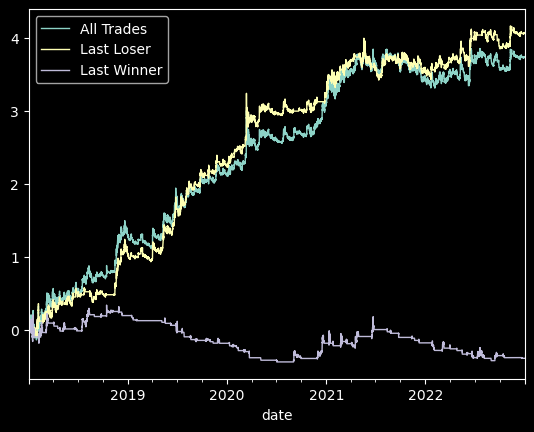

In [63]:
data = pd.read_csv('BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()

data['close'] = np.log(data['close'])
data['open']  = np.log(data['open'])
data['high']  = np.log(data['high'])
data['low']   = np.log(data['low'])
    
data['r'] =  (data['close']).diff().shift(-1)
data = addMovingAverages(data, 80, 80)
signal, returns = ATRBreakoutStrategy(data)
data['signal'] = signal
data['last_lose'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=False)
data['last_win'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=True)
   
orig = data['r'] * data['signal']
lose = data['r'] * data['last_lose']
win = data['r'] * data['last_win']
print("Original PF", orig[orig > 0].sum() / orig[orig < 0].abs().sum())
print("Last Lose PF", lose[lose > 0].sum() / lose[lose < 0].abs().sum())
print("Last Win PF", win[win > 0].sum() / win[win < 0].abs().sum())

plt.style.use('dark_background')
orig.cumsum().plot(label='All Trades')
lose.cumsum().plot(label='Last Loser')
win.cumsum().plot(label='Last Winner')
plt.grid(False)
plt.legend()
plt.show()

In [64]:
print(data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'r', 'middle_band', 'atr',
       'trend', 'band_upper', 'band_lower', 'signal', 'last_lose', 'last_win'],
      dtype='object')


In [65]:
data.columns = ['Open', 'High', 'Low', 'Close', 'Volume',  'r', 'middle_band', 'atr', 'trend',
       'band_upper', 'band_lower', 'signal', 'last_lose', 'last_win']
data.index.rename('Date', inplace=True)
data.dropna(inplace=True)

In [66]:
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'r', 'middle_band', 'atr',
       'trend', 'band_upper', 'band_lower', 'signal', 'last_lose', 'last_win'],
      dtype='object')


In [67]:
class _ATRBreakoutModified(Strategy):

    def init(self):

        self.close = self.data.Close
        self.last_lose = self.data.last_lose
            
        self.i = 0

    def next(self):
        
        if self.position and self.last_lose[self.i] == 0:
            self.position.close()
        
        if not self.position:
            if self.last_lose[self.i] == 1:
                self.buy(size = 0.2)
            elif self.last_lose[self.i] == -1:
                self.sell(size = 0.2)
        
        self.i += 1
        
print(len(data))
print(-364 * 24 * 3)
        
bt = Backtest(data, _ATRBreakoutModified,  margin=0.05, cash= 100)
_data = bt.run()
print(_data)

43573
-26208
Start                     2018-01-11 10:00:00
End                       2022-12-31 22:00:00
Duration                   1815 days 12:00:00
Exposure Time [%]                   57.973975
Equity Final [$]                   404.102119
Equity Peak [$]                    454.062364
Return [%]                         304.102119
Buy & Hold Return [%]                2.322585
Return (Ann.) [%]                   32.403472
Volatility (Ann.) [%]               32.184634
Sharpe Ratio                         1.006799
Sortino Ratio                        2.512841
Calmar Ratio                          1.35654
Max. Drawdown [%]                  -23.886845
Avg. Drawdown [%]                   -1.847059
Max. Drawdown Duration      591 days 10:00:00
Avg. Drawdown Duration       10 days 13:48:00
# Trades                                  412
Win Rate [%]                        37.378641
Best Trade [%]                       3.952814
Worst Trade [%]                     -1.025997
Avg. Trade [%]       

In [68]:
def show_trades(df: pd.DataFrame, columns: list[str], winners: bool = True, volume: bool = False, separator: str = 'mean'):
    if volume:
        raise Exception("Volume is not supported yet")
        
    plt.style.use('dark_background')

    # Calculate returns and start index
    df['returns'] = np.nan
    df['entry'] = np.nan
    
    for i in range(2, len(df)):
        if df.loc[i, 'signal'] != 0 and df.loc[i-1, 'signal'] == 0:
            entry_price = df.loc[i, 'close']
            start_index = i
        if df.loc[i, 'signal'] == 0 and df.loc[i-1, 'signal'] != 0:
            exit_price = df.loc[i, 'close']
            df.loc[i, 'returns'] = (exit_price - entry_price) / entry_price * np.sign(df.loc[i-1, 'signal'])
            df.loc[i, 'entry'] = start_index

    trade_returns = df['returns'].dropna()

    # Separate trades based on returns
    if separator == 'median':
        threshold = trade_returns.median()
    elif separator == 'mean':
        threshold = trade_returns.mean()
    elif separator == '75th percentile':
        threshold = trade_returns.quantile(0.75)
    else:
        raise ValueError("Invalid separator value")

    if winners:
        selected_trades = trade_returns[trade_returns > threshold]
    else:
        selected_trades = trade_returns[trade_returns <= threshold]
    
    selected_indices = random.sample(list(selected_trades.index), min(6, len(selected_trades)))
    
    # Prepare subplots
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axs = axs.flatten()

    for i, idx in enumerate(selected_indices):
        start_idx = int(df.loc[idx, 'entry'])
        trade_df = df.iloc[start_idx-1:idx+1]
        trade_df = trade_df.set_index('date')

        # Plot candlestick chart
        apds = [mpf.make_addplot(trade_df[col], ax=axs[i]) for col in columns]
        mpf.plot(trade_df, type='candle', style='charles', axtitle=f"Trade {i+1}: {'Buy' if df.loc[start_idx, 'signal'] > 0 else 'Sell'}", addplot=apds, ax=axs[i])
        
    for ax in axs:
        ax.grid(False)
    plt.tight_layout()
    plt.show()
    print("Number of trades: ", len(selected_trades), "out of", len(trade_returns))

Index(['open', 'high', 'low', 'close', 'volume', 'date', 'r', 'middle_band',
       'atr', 'trend', 'band_upper', 'band_lower', 'signal'],
      dtype='object')


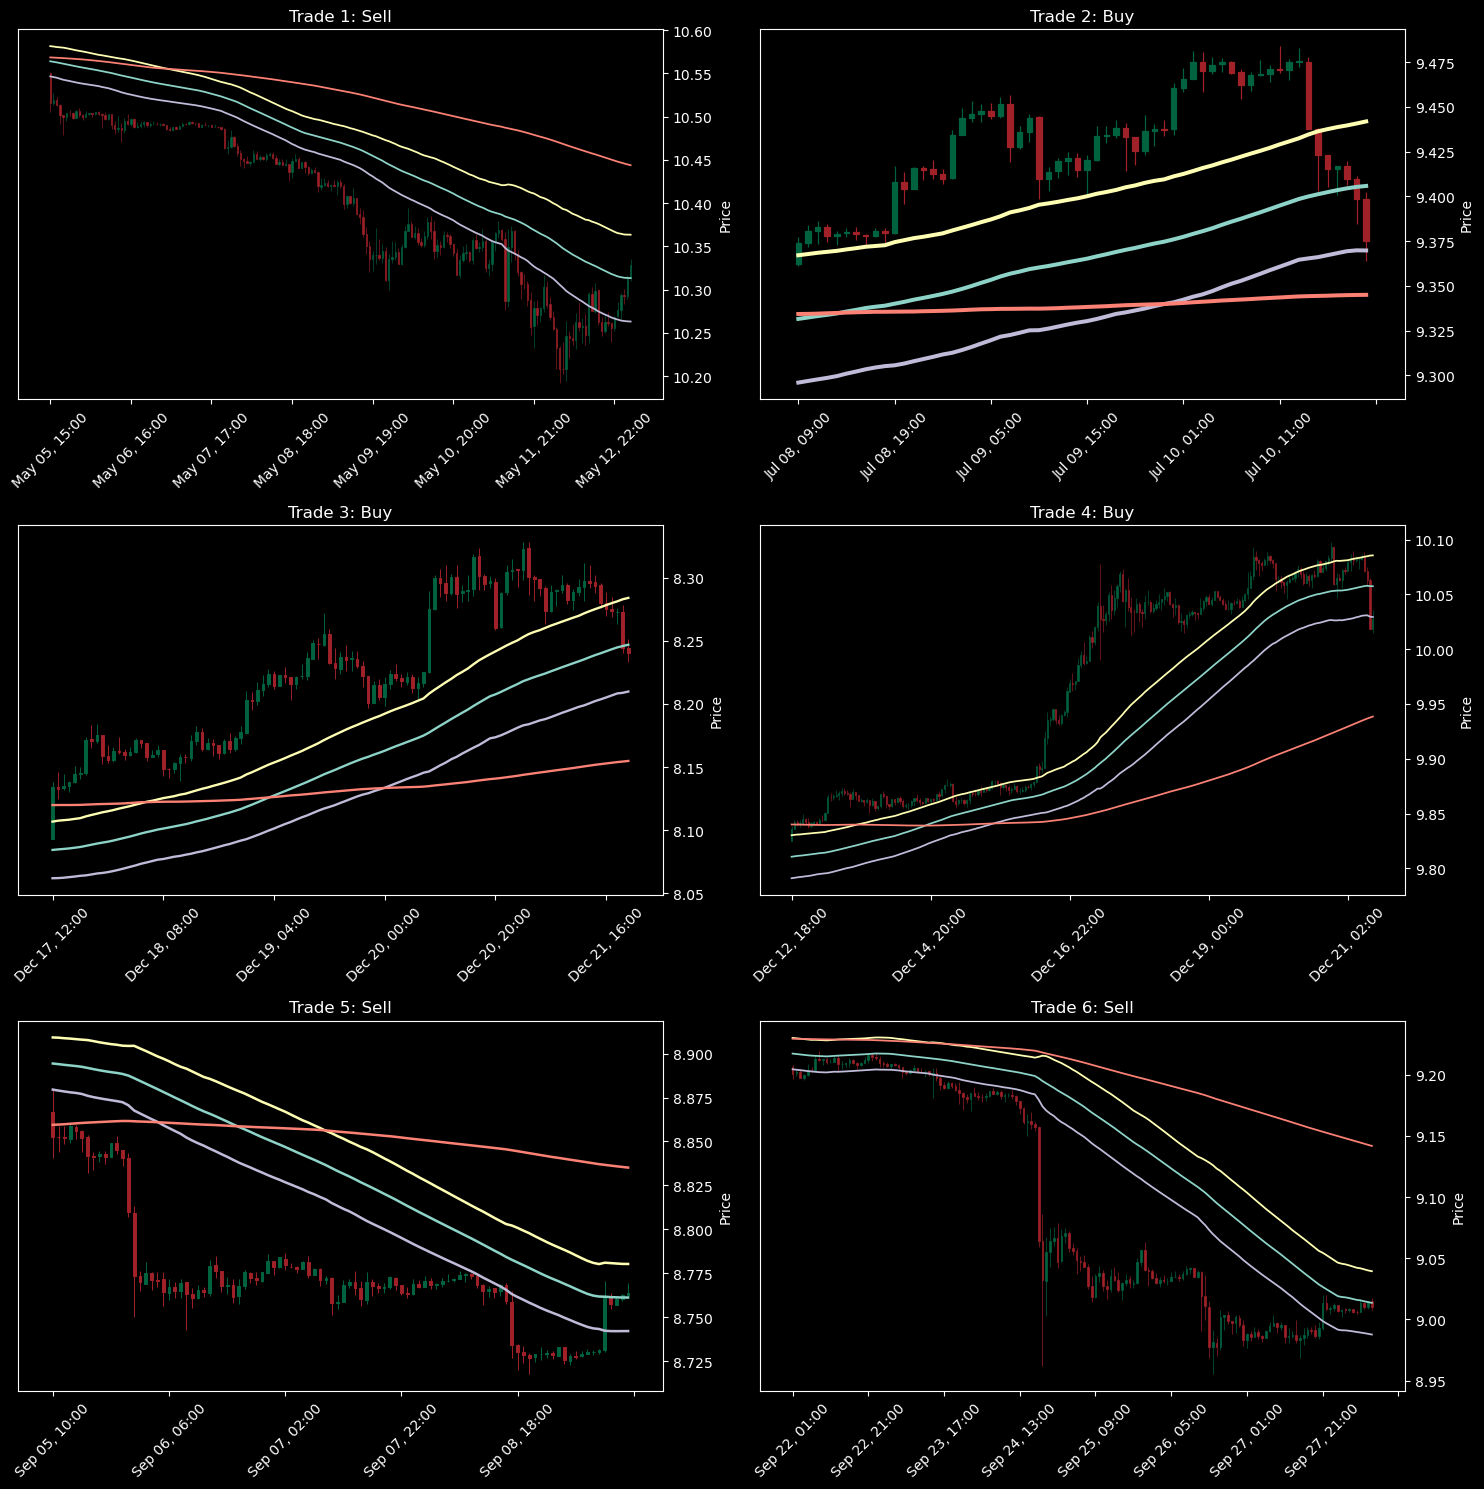

Number of trades:  134 out of 534


In [69]:
data = pd.read_csv('BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.dropna()

data['close'] = np.log(data['close'])
data['open']  = np.log(data['open'])
data['high']  = np.log(data['high'])
data['low']   = np.log(data['low'])
    
data['r'] =  (data['close']).diff().shift(-1)
data = addMovingAverages(data, 80, 80)
signal, returns = ATRBreakoutStrategy(data)
data['signal'] = signal

print(data.columns)

show_trades(data, ['middle_band', 'band_upper', 'band_lower', 'trend'], separator="75th percentile", winners=True)